<a href="https://colab.research.google.com/github/sahana3131/ML4SCI-QMLHEP03/blob/main/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implement a Message Passing Neural Network (MPNN) with a framework of your choice (PyTorch Geometric, Deep Graph Library, GraphNets) to classify jets as being quarks or gluons. 

## Data Preparation

In [1]:
!wget -qq "https://zenodo.org/record/3164691/files/QG_jets.npz"

In [2]:
import numpy as np
import pandas as pd

In [3]:
#Load Dataset
temp = np.load('QG_jets.npz')

In [4]:
print(temp.files)

['X', 'y']


In [5]:
print(len(temp["X"]))

100000


In [6]:
print((temp["y"]))

[1. 1. 1. ... 1. 0. 0.]


Now let's see the distribution of our data

array([[<Axes: title={'center': '0'}>]], dtype=object)

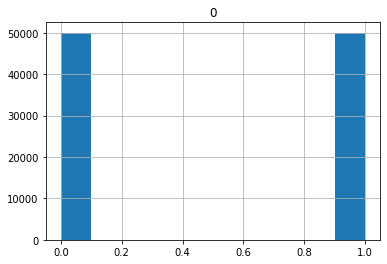

In [7]:
y=pd.DataFrame(temp["y"])

y.hist()

As we can see the data is unbiased having similar number of quarks and gluons

In [8]:
X=[]
for i in temp["X"]:
    X.append(i[0])
X=pd.DataFrame(X,columns=["pt","eta","azimuthal","pgdid"])
y=pd.DataFrame(temp["y"],columns=["Y"])
X["y"]=y
#X=X.sample(frac=0.5, replace=False, random_state=1)

In [9]:
X.head(10)
#print(len(X))

,pt,eta,azimuthal,pgdid,y
0,0.268769,0.356903,4.741387,22.0,1.0
1,1.212663,-0.112853,3.047088,-211.0,1.0
2,0.216829,-0.997057,0.532569,22.0,1.0
3,0.413806,0.956889,5.742566,211.0,1.0
4,0.476434,-0.403307,4.126747,22.0,1.0
5,7.702450,-0.819775,5.794888,321.0,0.0
6,0.235739,-1.094473,5.626174,211.0,1.0
7,0.317746,0.245092,1.284100,211.0,1.0
8,0.879651,0.109774,3.468267,211.0,1.0
9,0.160245,-1.455975,3.670505,22.0,1.0


In [10]:
X=X[:50000]

Taking only some part of the data as all-to-all connected graph flows out of memory for more data

<Axes: >

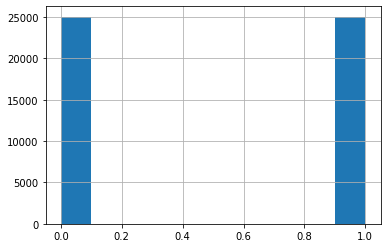

In [11]:
y=X["y"]
X=X.drop(["y"],axis=1)
y.hist()

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [13]:
print(len(X_train))

35000


## DGL

In [14]:
!pip install --upgrade dgl
import dgl
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import networkx as nx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 29.9 MB/s eta 0:00:00


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Adding nodes and edges to the graph

In [15]:
def build_graph(edges):
    g = dgl.DGLGraph()
    g.add_nodes(len(X))
    src, dst = tuple(zip(*edges))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bidirectional
    g.add_edges(dst, src)
    return g

In [16]:
edge_list=[]
from itertools import combinations  
import random
# for i in range(len(X_train)):
#     for j in range(i,len(X_train)):
#         dist=np.linalg.norm(X_train.iloc[i]-X_train.iloc[j])
#         if(dist<5):
#             edge_list.append((X_train.iloc[i],X_train.iloc[j]))
edges=random.sample(range(1, len(X_train)), int(len(X_train)/30))
edge_list=combinations(edges,2)

In [17]:
edge_list=list(edge_list)

In [18]:
print(len(edge_list))

679195


In [19]:
G = build_graph(edge_list)

/usr/local/lib/python3.9/dist-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [20]:
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 50000 nodes.
We have 1358390 edges.


In [35]:
import torch.nn as nn
import torch.nn.functional as F
def gcn_message(edges):
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}
    # Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        g.ndata['h'] = inputs
        g.send(self,g.edges(), gcn_message, etype='default')
        g.recv(g.nodes(), gcn_reduce)
        h = g.ndata.pop('h')
        return self.linear(h)
        import dgl.function as fn



In [48]:
import dgl.function as fn

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.linear1 = nn.Linear(in_feats, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.linear1(inputs)
        g.ndata['h'] = h
        g.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
        h = g.ndata['h']
        h = self.linear2(h)
        return h

net = GCN(4, 10, 2)

In [49]:
inputs = torch.tensor(X.values)#torch.eye(node_count)
labeled_nodes = torch.tensor(y_train[::3].index)
labels = torch.tensor(y_train[::3].values)  # their labels are different

In [50]:
print(max(y_train[::3].keys()),len(labels))

49997 11667


In [51]:
!pip install send

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
all_preds = []
epochs = 10
losses=[]
for epoch in range(epochs):
    preds = net(G, inputs.float())
    all_preds.append(preds)
    # we only compute loss for labeled nodes
    print(len(preds),len(labels))
    loss = F.cross_entropy(preds[labeled_nodes], labels.long())
    losses.append(loss)
    optimizer.zero_grad() # PyTorch accumulates gradients by default
    loss.backward() 
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

50000 11667
Epoch 0 | Loss: 58.6864
50000 11667
Epoch 1 | Loss: 131.6757
50000 11667
Epoch 2 | Loss: 83.0804
50000 11667
Epoch 3 | Loss: 4.8017
50000 11667
Epoch 4 | Loss: 17.6266
50000 11667
Epoch 5 | Loss: 4.5555
50000 11667
Epoch 6 | Loss: 22.4313
50000 11667
Epoch 7 | Loss: 24.5332
50000 11667
Epoch 8 | Loss: 13.4428
50000 11667
Epoch 9 | Loss: 4.7406


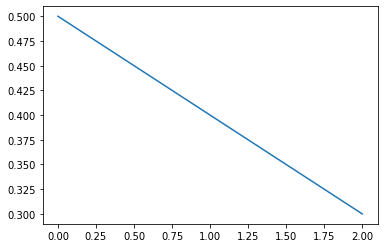

In [57]:
import matplotlib.pyplot as plt
import torch

losses = torch.tensor([0.5, 0.4, 0.3], requires_grad=True)

plt.plot(range(len(losses)), losses.detach().numpy())
plt.show()



In [58]:
last_epoch = all_preds[epochs-1].detach().numpy()
predicted_class = np.argmax(last_epoch, axis=-1)
color = np.where(predicted_class==0, 'g', 'p')

print(predicted_class)
print(color)

[1 1 1 ... 1 1 1]
['p' 'p' 'p' ... 'p' 'p' 'p']


In [59]:
print(len(predicted_class),len(y))

50000 3


In [62]:
from sklearn.metrics import accuracy_score
if len(predicted_class) != len(y):
    print("Error: predicted_class and y have different lengths")
else:
    # Calculate the accuracy score
    acc = accuracy_score(predicted_class, y)

    print(acc)  # Prints 1.0 (100% accuracy)


Error: predicted_class and y have different lengths
